## TODO: For now we only segment the liver
- **Figure out why the train and validation loss are so different. Plot looks weird.**
- Make training more stable.
- Then train it for 3-4 days.
- Write function to run it on all images, output dice per scan and avg dice. Which images work well and which don’t?
- Connected component post-processing.

Inspiration for improvements: **nnU-Net: Self-adapting Framework
for U-Net-Based Medical Image Segmentation** (https://arxiv.org/pdf/1809.10486.pdf)

In [1]:
# imports
import matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import json
import warnings
from random import randint
import random
import SimpleITK as sitk
from multi_slice_viewer import multi_slice_viewer
from IPython.display import clear_output
import pickle 
from tqdm import tqdm_notebook as tqdm
import warnings
import h5py
import ipywidgets
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv3D, MaxPooling3D, Dropout, Conv3DTranspose, UpSampling3D, concatenate, Cropping3D, Reshape, BatchNormalization
import keras.callbacks
from keras import backend as K
from keras import optimizers
from keras import regularizers
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from tensorflow.python.client import device_lib
from keras.utils import multi_gpu_model

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [2]:
# check if we use gpu or cpu
print(device_lib.list_local_devices())
print(tf.test.is_gpu_available())
print(K.tensorflow_backend._get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12708321216887263758
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1788466411457899457
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1300828307029982900
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16324862534411263626
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322644890
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13109609844691788338
physical_device_desc: "device: 0, name: Tesla K40m, pci bus id: 0000:02:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 11322644890
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnat

In [3]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
assert len(K.tensorflow_backend._get_available_gpus()) > 0

In [ ]:
# Task03_liver dir in same directory as notebook
data_path = './Task03_Liver/'

In [ ]:
# info about dataset in json file
with open(data_path + 'dataset.json') as f:
    d = json.load(f)   
    
    # paths to training set images with label
    train_paths = d['training']
    
    # paths to testset images with label
    test_paths = d['test'] 

In [ ]:
# change to data dir 
os.chdir(data_path)
print(os.getcwd())

# Load the train set as SITK images

In [ ]:
# generators that hold sitk images, not much memory usage..
train_imgs = (sitk.ReadImage(train_instance['image']) for train_instance in train_paths)
train_lbls = (sitk.ReadImage(train_instance['label']) for train_instance in train_paths)

## Resampling
Images do not have the same spacings. We will first resample. For this we need the spacings in the SITK images. Note that when converting sitk to numpy the z axis is placed at the front. Spacings in order: (x, y, z), numpy image: (z, x, y)

Resample to 1mm x 1mm x 1mm resolution => images should have different sizes (not all 512 x 512 x N anymore). 
For example, when the image has a shape of (512, 512, 74) and a spacing of (0.75, 0.75, 2),
you can calculate how wide the image is along the x-axis: 512 * 0.75 mm = 384 mm. As a tip, look for “scipy zoom”.

In [ ]:
# now load one image and label at a time
def resample_and_save(sitk_gen, order, filename, length):     
    print('Storing resampled dataset at {}.'.format(os.path.join(os.getcwd(), filename)))    
    i = 0
    
    # make a h5py file to store images as numpy in
    with h5py.File(filename, 'w') as f: 
        for img in tqdm(sitk_gen, total=length):             
#             print('Image index: {}.'.format(i))
            
            # get the spacing
            spacing = img.GetSpacing()
            # change order
            x, y, z = spacing  
            spacing = (z, x, y)      # order: (z, x, y)

            # convert to numpy
            np_img = sitk.GetArrayFromImage(img)

            # apply zoom, order 3 for images
            np_img_re = zoom(np_img, spacing, order=order)
            
#             print("Before: {}, after: {}".format(np_img.shape, np_img_re.shape))

            # save the resamples img/label
            dataset = f.create_dataset(str(i), data=np_img_re)
            i+=1

In [ ]:
# use order 3 interpolation for imgs, order 1 
resample_and_save(train_imgs, order=3, filename='resampled_train_imgs.h5py', length=len(train_paths))
resample_and_save(train_lbls, order=0, filename='resampled_train_lbls.h5py', length=len(train_paths))

## Start here if you saved the resampled images and labels

In [4]:
# change to data dir
data_path = './Task03_Liver/'
os.chdir(data_path)
print(os.getcwd())

/nfs/home1/tdado/ISMI_project/Task03_Liver


In [5]:
# load from disk
np_train_imgs = []
np_train_lbls = []

with h5py.File('resampled_train_imgs.h5py', 'r') as f: 
    for img in tqdm(f):
        dset = f[img]
        np_train_imgs.append(dset[:])
    
with h5py.File('resampled_train_lbls.h5py', 'r') as f: 
    for lbl in tqdm(f):
        dset = f[lbl]     
        np_train_lbls.append(dset[:])

## Make the labels binary
For now we will focus on only on segmentation of the liver. Set the cancer labels to liver labels. Remove this line if you want to segment cancer aswell.

In [6]:
np_train_lbls = [np.where(lbl != 2, lbl, 1) for lbl in np_train_lbls]

## Do we have imbalances in our data? 

In [7]:
# count the labels of train images
sums = np.zeros(3)
for lbs in np_train_lbls:
    labels, counts = np.unique(lbs, return_counts=True)
    
    # if there are only 2 labels
    if len(counts) == 2:
        sums[:2]+=counts
    else:
        sums+=counts

In [8]:
# print percentages of voxels.
total = sum(sums)
print("{:.2f}% background, {:.2f}% liver, {:.2f}% cancer.".format(sums[0]/total*100, sums[1]/total*100, sums[2]/total*100))

97.72% background, 2.28% liver, 0.00% cancer.


In [9]:
weights = sum(sums[:2]) / (2.0 * sums[:2])
print("class weights: ", weights)

class weights:  [  0.51166062  21.9396808 ]


In [10]:
class DataSet:
    
    def __init__(self, imgs, lbls=None):
        self.imgs = imgs
        self.lbls = lbls
    
    def get_lenght(self):
        return len(self.imgs)
    
    def show_image(self, i):
        if self.lbls != None: 
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial', overlay_1=self.lbls[i], overlay_1_thres=1, 
                   overlay_2=self.lbls[i], overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)
        else:
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial')  

# Split for training and validation

In [11]:
# make a small data set of training images, as numpy
validation_percent = 0.2 # coefficient to define validation dataset (value between 0 and 1)
n_validation_imgs = int(validation_percent * len(np_train_imgs))

val_set   = DataSet(np_train_imgs[:n_validation_imgs], np_train_lbls[:n_validation_imgs])
train_set = DataSet(np_train_imgs[n_validation_imgs:], np_train_lbls[n_validation_imgs:])

print('{} images in val set'.format(val_set.get_lenght()))
print('{} images in train set'.format(train_set.get_lenght()))

26 images in val set
105 images in train set


# Patch extractor
We re-use the patch extractor from assignment 7, but modify it to get 3D patches from a 3D image.
We can add augmentations later in the patch extractor. Note the extra dimension in the shape of patch_out and target_out. 

In [12]:
class PatchExtractor:

    def __init__(self, patch_size, fromLiver):
        self.patch_size = patch_size 
        self.fromLiver = fromLiver
    
    def get_patch(self, image, label):
        ''' 
        Get a 3D patch of patch_size from 3D input image, along with corresponding 3D label map.
        Pick random location of the patch inside the image. The point is at the center of the patch.
        We first pad the image to not go out of bounds when extracting the patch.
        image: a numpy array representing the input image
        label: a numpy array representing the labels corresponding to input image
        '''
        
        # size of patch in each dimension
        pz, px, py = self.patch_size
        
#         print('Patch_size: {}'.format(patch_size))
#         print('Image_size: {}'.format(image.shape))

        # pad with the min value in the image
        min_val = np.min(image)
        
        # pad with half the patch size, I assume even patch size
        padded_img = np.pad(image, ((pz//2, pz//2), (px//2, px//2), (py//2, py//2)), 'constant', constant_values=min_val)
        padded_lbl = np.pad(label, ((pz//2, pz//2), (px//2, px//2), (py//2, py//2)), 'constant')
        
#         print('Padded_size: {}'.format(padded_img.shape))

        # centre of the patch: a random point from the liver in the non padded image
        if self.fromLiver:
            # getting the liver labeled points
            liver_ind = np.argwhere(label == 1)  
            
            # get a random point from the liver labeled points
            r = randint(0, len(liver_ind))
            z = liver_ind[r][0]
            x = liver_ind[r][1]
            y = liver_ind[r][2]
            
        # centre of the patch: a random location in the non padded image    
        else:
            dims = image.shape
            z = randint(0, dims[0]) 
            x = randint(0, dims[1]) 
            y = randint(0, dims[2])   
            
        # z, x, y is the left bottom corner of the patch in the padded image (index shift with pad size)     
        # take a patch, with the random point at the center in the padded img
        patch  = padded_img[z:z+pz, x:x+px, y:y+py].reshape(pz, px, py, 1)
        target = padded_lbl[z:z+pz, x:x+px, y:y+py].reshape(pz, px, py, 1)

        return patch, target

(156, 156, 156, 1)
(156, 156, 156, 1)


<IPython.core.display.Javascript object>


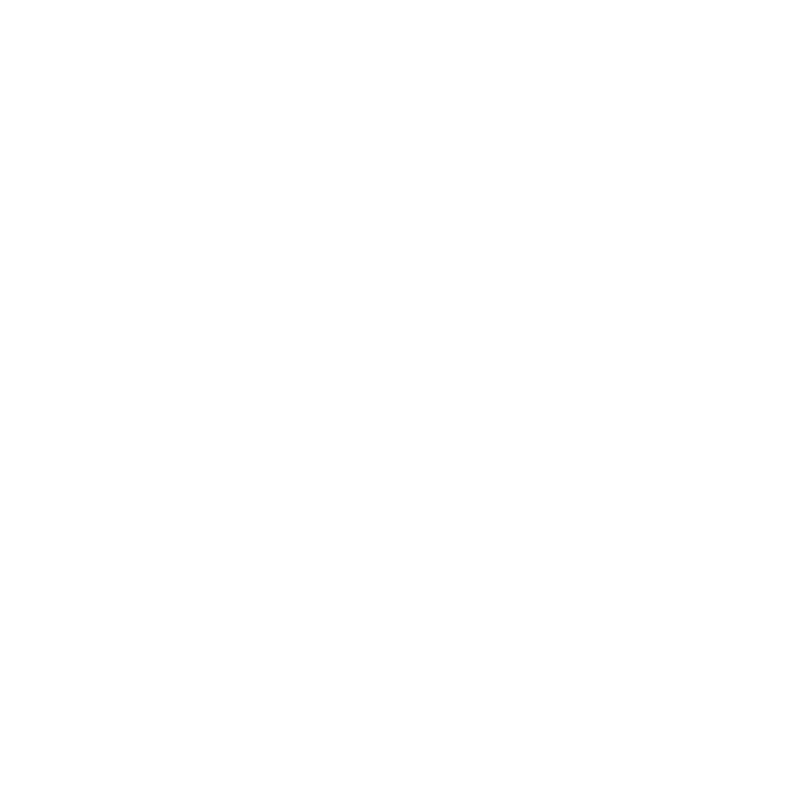

In [13]:
# get an image and a label from our train set
image = train_set.imgs[0]
label = train_set.lbls[0]

# test PatchExtractor
patch_size = (156, 156, 156)
patch_extractor = PatchExtractor(patch_size=patch_size, fromLiver=True)

# lets check some patches
patch, target = patch_extractor.get_patch(image, label)

print(patch.shape)
print(target.shape)

# show patch
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(patch.reshape(patch_size), view='axial', overlay_1=target.reshape(patch_size), overlay_1_thres=1, 
                   overlay_2=target.reshape(patch_size), overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

# Batch creator
Lets also reuse the batch creator from assignment 7. We are going to use valid convolutions, which means the output of our network will be smaller than the input. The purpose of this batchcreator is the make batches consisting of patches with their corresponding labels (for the network to train on). Since a UNet with valid convolutions has a smaller output than input, we need to crop the label based on the target size aswell. And labels should be in onehot.

In [14]:
class BatchCreator:
    
    def __init__(self, patch_extractor, dataset, target_size):
        self.patch_extractor = patch_extractor
        self.target_size = target_size # size of the output, can be useful when valid convolutions are used        
        self.imgs = dataset.imgs
        self.lbls = dataset.lbls                
        self.n = len(self.imgs)
        self.patch_size = self.patch_extractor.patch_size
    
    def create_image_batch(self, batch_size):
        '''
        returns a single (batch of?) patches (x) with corresponding labels (y) in one-hot structure
        '''
        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size, 1))  # 1 channel
        y_data = np.zeros((batch_size, *self.target_size, 2)) # one-hot encoding with 2 classes
        
        for i in range(0, batch_size):
        
            random_index = np.random.choice(len(self.imgs))                   # pick random image
            img, lbl = self.imgs[random_index], self.lbls[random_index]       # get image and segmentation map
            
            # clip values outside [-1000, 3000] and normalize image intensity to range [0., 1.]      
            img = np.clip(img, -1000, 3000)
            img = (img - np.min(img)) / np.ptp(img)     
            
            # get a patch with corresponding labels from the patch extractor
            patch_img, patch_lbl = self.patch_extractor.get_patch(img, lbl)   
            
            # crop labels based on target_size           
            ph = (self.patch_extractor.patch_size[0] - self.target_size[0]) // 2    
            pw = (self.patch_extractor.patch_size[1] - self.target_size[1]) // 2
            pd = (self.patch_extractor.patch_size[2] - self.target_size[2]) // 2
            
            # take the cropped patch, it contains labels with values 0,1,2
            cropped_patch = patch_lbl[ph:ph+self.target_size[0], pw:pw+self.target_size[1], pd:pd+self.target_size[2]].squeeze() 
            
            # instead of 0,1,2 label values we want categorical/onehot => 0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]
            onehot = to_categorical(cropped_patch, num_classes=2)
            
            x_data[i, :, :, :, :] = patch_img
            y_data[i, :, :, :, :] = onehot
        
        return (x_data.astype(np.float32), y_data.astype(np.float32))
    
    def get_image_generator(self, batch_size):
        '''returns a generator that will yield image-batches infinitely'''
        while True:
            yield self.create_image_batch(batch_size)

# 3D UNet Model
Start with this model, we can adapt this later if needed. Build like the net from: 
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.

In [15]:
# make block of two convolve3D's
def unet_block(inputs, n_filters, padding, up_conv=False, batchnorm=False):
    # 3d convolve, 32 3x3x3 filters 
    c1 = Conv3D(n_filters, (3,3,3), activation='relu', padding=padding)(inputs)
    if batchnorm:
        c1 = BatchNormalization()(c1)
    
    # up conv (normal conv in the expanding path) has same number of filters twice
    if up_conv:
        c2 = Conv3D(n_filters, (3, 3, 3), activation='relu', padding=padding)(c1)
    else:          # normal convs have twice the filters in the second conv
        c2 = Conv3D(n_filters*2, (3, 3, 3), activation='relu', padding=padding)(c1)
        
    if batchnorm:
        c2 = BatchNormalization()(c2)
    
    return c2

In [16]:
# 3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.
def build_unet_3d(initial_filters, padding, batchnorm=False):
    
    ## CONTRACTING PATH
    
    # (spac_dim_1, space_dim_2, space_dim_3, channels)
    inputs = Input(shape=(156, 156, 156, 1))

    # First conv pool, 32 filters and 64 filters    
    block_1    = unet_block(inputs, initial_filters, padding=padding, batchnorm=batchnorm) 
    max_pool_1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_1)  # 2×2×2 max pooling with strides two
                                                                        # needs even spacial_dimensions as input
    # second conv pool, 64 filters, 128 filters    
    block_2    = unet_block(max_pool_1, initial_filters*2, padding=padding, batchnorm=batchnorm)
    max_pool_2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_2)
    
    # third conv pool, 128 filters, 256 filters    
    block_3    = unet_block(max_pool_2, initial_filters*4, padding=padding, batchnorm=batchnorm)
    max_pool_3 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_3)
    
    # just a conv block without maxpooling, 256 filters and 512 filters
    conv_4     = unet_block(max_pool_3, initial_filters*8, padding=padding, batchnorm=batchnorm)
    
    ## EXPANDING PATH   
    
    #TODO: check Conv3DTranspose correctly applied
    
    # round 1
    up_conv_3  = Conv3DTranspose(16*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(conv_4)
    crop_3     = Cropping3D(cropping=4)(block_3) 
    concat_3   = concatenate([crop_3, up_conv_3])  
    up_block_3 = unet_block(concat_3, 8*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 2
    up_conv_2  = Conv3DTranspose(8*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_3) 
    crop_2     = Cropping3D(cropping=16)(block_2) 
    concat_2   = concatenate([crop_2, up_conv_2])  
    up_block_2 = unet_block(concat_2, 4*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 3
    up_conv_1  = Conv3DTranspose(4*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_2) 
    crop_1     = Cropping3D(cropping=40)(block_1) 
    concat_1   = concatenate([crop_1, up_conv_1])  
    up_block_1 = unet_block(concat_1, 2*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # finish with 1x1x1 conv, 3 filters, # labels, softmax or ReLU?
    finish = Conv3D(2, (1,1,1), activation='softmax', padding=padding)(up_block_1)
    
    model = Model(inputs, finish) 
    print(model.summary(line_length=150))
    
    return model

In [17]:
unet_3d = build_unet_3d(initial_filters=32, padding='valid', batchnorm=False)

Instructions for updating:
Colocations handled automatically by placer.
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             (None, 156, 156, 156, 1)         0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                (None, 154, 154, 154, 32)        896               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv3d_2 (Conv3D)     

## Testing the batch generator

In [18]:
# define parameters for the batch creator
patch_size  = (156, 156, 156)  # isotropic patch size
target_size = (68, 68, 68)     # output size, smaller since valid convolutions are used
batch_size  = 2                # number of patches in a mini-batch, for segmentation 1 is fine, since the 
                               # output of the net is many thousands of values per patch, which all contribute to the loss

# initialize patch generator and batch creator
patch_generator       = PatchExtractor(patch_size, fromLiver=True)
batch_generator_train = BatchCreator(patch_generator, train_set, target_size=target_size)
batch_generator_val   = BatchCreator(patch_generator, val_set, target_size=target_size)

# get one minibatch
x_data, y_data = batch_generator_train.create_image_batch(batch_size)

print("(batch, d, h, w, channels)")
print('xdata has shape: {}'.format(x_data.shape))
print('ydata has shape: {}'.format(y_data.shape))
print('Occuring values in true labels: {}'.format(np.unique(y_data)))
print('Min of input: {}'.format(np.min(x_data)))
print('Max of input: {}'.format(np.max(x_data)))

(batch, d, h, w, channels)
xdata has shape: (2, 156, 156, 156, 1)
ydata has shape: (2, 68, 68, 68, 2)
Occuring values in true labels: [ 0.  1.]
Min of input: 0.0
Max of input: 0.6857683062553406


## Define a logger which saves the losses and saves the best model

In [19]:
class Logger(keras.callbacks.Callback):

    # logg losses, removed accs for now
    def __init__(self, data_dir, model_name):  
        self.model_filename = os.path.join(data_dir, model_name + '.h5')        
        self.tr_losses = []  
        self.val_losses = []      
        self.best_val_loss = float("inf") 
        self.best_model = None     
       
    def on_epoch_end(self, batch, logs={}):
        # add validation info
        self.val_losses.append(logs.get('val_loss'))
        self.tr_losses.append(logs.get('loss'))
        
        # per 30 epochs, training loss should improve with 5 × 10−3
        # else: learning rate was reduced by factor 5.
        keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.005)
        
        # Training termination if val loss improvement < 0.005 within last 60 epochs & lr < 0.000001
        # min_delta = 0.005
        keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=60, verbose=1, mode='auto', 
                                      baseline=None, restore_best_weights=False)
        
        self.plot()

        # safe best model after epoch end
        if self.val_losses[-1] < self.best_val_loss:
            self.best_val_loss = self.val_losses[-1]
            self.model.save(self.model_filename) # save best model to disk
            print('Best model saved as {}'.format(self.model_filename))
         
    def plot(self): 
        clear_output()
        plt.figure(figsize=(8, 4))
#         plt.ylim([0, 0.8])
        n = len(self.val_losses) + 1         
        plt.plot(range(1, n), self.tr_losses, label='train loss')         
        plt.plot(range(1, n), self.val_losses, label='val loss')        
        plt.legend(loc='lower left')
        plt.show()

In [20]:
# make a data dir to store best model
print(os.getcwd())
data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

/nfs/home1/tdado/ISMI_project/Task03_Liver


In [21]:
# back to inline, I don't know how to plot in notebook mode
%matplotlib inline

## Dice Loss
Dice loss seems to be a good pick for 3D segmentation with class inbalances. We have to look if this works like this.
In our case y_pred is output of the softmax.(see https://arxiv.org/pdf/1707.03237.pdf)

$$ \textbf{Dice loss} =  1 - \frac{2 \hspace{0.3em}|X \cap Y|}{|X|+ |Y|} $$


**For binary volumes of N voxels (Milletari et al., 2016, VNet):**

$$ \textbf{Dice loss} = 1 -\frac{2 \sum_{i}^{N} p_{i} g_{i}}{\sum_{i}^{N} p_{i}^{2}+\sum_{i}^{N} g_{i}^{2}} $$

In [22]:
# dice loss as above
def dice_loss_bv(y_true, y_pred, epsilon=1e-6):
    ''' 
    Dice loss calculation.
    Assumes the channels_last format.
    y_true: One hot encoding of ground truth
    y_pred: Network output, must sum to 1 over c channel (such as after softmax) 
    '''
    # for every voxel of the prediction the probabililty of being foreground (liver
    P = K.sum(y_pred * [0., 1.], axis=-1)
    
    # for every voxel of the groundtruth the label (0: background, 1: foreground)
    G = K.sum(y_true * [0., 1.], axis=-1)
    
    return 1. - (2. * K.sum(P * G) + epsilon) / (K.sum(P**2.) + K.sum(G**2.) + epsilon) + keras.losses.categorical_crossentropy(y_true, y_pred)

**Proposed in Milletari et al. [8] as a loss function, the 2-class variant of the Dice loss, denoted DL2, can be expressed as**

$$
\mathrm{DL}_{2}=1-\frac{\sum_{n=1}^{N} p_{n} r_{n}+\epsilon}{\sum_{n=1}^{N} p_{n}+r_{n}+\epsilon}-\frac{\sum_{n=1}^{N}\left(1-p_{n}\right)\left(1-r_{n}\right)+\epsilon}{\sum_{n=1}^{N} 2-p_{n}-r_{n}+\epsilon}
$$

Sudre, Carole H., et al. "Generalised dice overlap as a deep learning loss function for highly unbalanced segmentations." https://arxiv.org/pdf/1707.03237.pdf


**Let R be the reference foreground segmentation
(gold standard) with voxel values $r_n$, and P the predicted probabilistic map for the foreground label over N image elements $p_n$, with the background class probability being 1 − P. ***

In [23]:
def dice_loss(y_true, y_pred, epsilon=1e-6):
    ''' 
    Dice loss calculation in a binary classification (foreground vs. background) formulation.
    Assumes the channels_last format.
    y_true: One hot encoding of ground truth
    y_pred: Network output, must sum to 1 over c channel (such as after softmax) 
    '''
    # for every voxel of the prediction the probabililty of being foreground (liver
    P = K.sum(y_pred * [0., 1.], axis=-1)
    
    # for every voxel of the groundtruth the label (0: background, 1: foreground)
    R = K.sum(y_true * [0., 1.], axis=-1)
    
    a = K.sum(P * R) + epsilon
    b = K.sum(P + R) + epsilon
    c = K.sum((1 - P) * (1 - R)) + epsilon 
    d = K.sum((2 - P - R)) + epsilon
    
    return (1 - a/b - c/d) + keras.losses.categorical_crossentropy(y_true, y_pred)

In [42]:
def loss(y_true, y_pred, weights=weights):
    '''# 97.98% background, 1.91% liver, 0.11% cancer.
        weights = sum(sums) / (3.0 * sums)
        print("class weights: ", weights)'''
#     weights = K.variable(weights)
#     # scale predictions so that the class probas of each sample sum to 1
#     y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
#     # clip to prevent NaN's and Inf's
#     y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#     # calc
#     loss = y_true * K.log(y_pred) * weights
#     loss = -K.sum(loss, -1)
    return keras.losses.categorical_crossentropy(y_true, y_pred)

In [39]:
print(weights)
print(type(weights))
class_weights = {0: weights[0], 1: weights[1]}
print(class_weights)

[  0.51166062  21.9396808 ]
<class 'numpy.ndarray'>
{0: 0.51166062136303914, 1: 21.939680804011854}


## Now we define parameters, compile the model and train the network 

In [55]:
# make the model use multiple gpus, I think batchsize should be a multiple of #gpu's
model = multi_gpu_model(unet_3d, gpus=2)
# model = unet_3d

In [56]:
learning_rate   = 10**-3
optimizer       = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# loss            = 
steps_per_epoch = 100
epochs          = 100
logger          = Logger(data_dir, '3D-UNet-29-05')

image_generator_train = batch_generator_train.get_image_generator(batch_size)
image_generator_val   = batch_generator_val.get_image_generator(batch_size)

# compile model
model.compile(optimizer=optimizer, loss=loss)

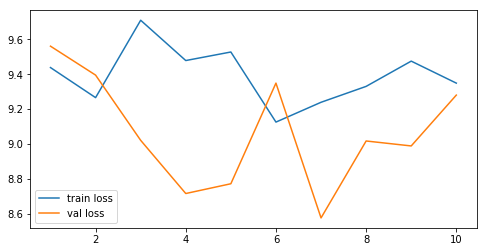

Epoch 11/100
 43/100 [===========>..................] - ETA: 11:30 - loss: 9.4992

In [ ]:
# train the model
model.fit_generator(generator=image_generator_train, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=image_generator_val,
                    verbose=1,
                    validation_steps=20,
                    callbacks=[logger],
                   class_weight=weights)

## Getting the full segmentation map
Like this but then 3D:

![seg_diagram.png](seg_diagram.png)


In [ ]:
def padding(image, patch_size, target_size):
    """
    Adding the red border (see example above) to the image. Which is needed for when we don't have full context. 
    Pad with lowest occuring values.
    image       : the input image (as numpy)
    patch_size  : patch_size of the input for the UNet
    target_size : output size of the model, needed to calculate how much to padd in each dimension. 
    """
    z, y, x = patch_size
    
    # pad with min value from image, always safe
    min_val = np.min(image)
    
    # size of padding for each dimension
    pad_z = (z - target_size[0]) // 2
    pad_x = (x - target_size[1]) // 2
    pad_y = (y - target_size[2]) // 2
    
    # pad with a tuple for how much on each side for every dimension
    padded_input = np.pad(image, ((pad_z, pad_z), (pad_x, pad_x), (pad_y, pad_y)), 'constant', constant_values=min_val)
    
    return padded_input

In [ ]:
def predict_image_segmentation(model, image, target_size, patch_size):
    """
    Give a full segmentation map (same size as input_image) using the model. 
    model       : the model to do the prediction
    image       : the input image (as numpy)
    target_size : output size of the model (since we use valid convutions the output gets smaller)
    patch_size: : the size of the patch that is put into the model
    """
    
    # clip values outside [-1000, 3000] and normalize image intensity to range [0., 1.]      
    image = np.clip(image, -1000, 3000)
    image = (image - np.min(image)) / np.ptp(image)    
    
    # pad the input image:
    pad_img = padding(image, patch_size, target_size)  

    print("Image size: {}".format(image.shape))
    print("Padded image size: {}".format(pad_img.shape))
    
    dims = image.shape
    # how many times target size fits in a dimension 
    pz = dims[0] // target_size[0] 
    px = dims[1] // target_size[1] 
    py = dims[2] // target_size[2] 
    
    # segmentation map, same size as input image
    segmentation = np.zeros(image.shape)   
    
    for z in range(pz, -1, -1):         
        for x in range(px, -1, -1):
            for y in range(py, -1, -1):  
                
                # shift starting point with target_size
                start_z = z * target_size[0]
                start_x = x * target_size[1]
                start_y = y * target_size[2]
                
                # if the patch does not fit:
                if start_z + patch_size[0] > pad_img.shape[0]:
                    start_z = pad_img.shape[0] - patch_size[0]
                if start_x + patch_size[1] > pad_img.shape[1]:
                    start_x = pad_img.shape[1] - patch_size[1]
                if start_y + patch_size[2] > pad_img.shape[2]:
                    start_y = pad_img.shape[2] - patch_size[2]
                
                # Get patch: shift with target_size, take patch_size                
                patch = pad_img[start_z:start_z + patch_size[0], 
                                start_x:start_x + patch_size[1], 
                                start_y:start_y + patch_size[2]]     

                # Reshape for u-net and make prediction:
                patch = np.reshape(patch, (1, patch_size[0], patch_size[1], patch_size[2], 1))
                prediction = model.predict(patch)

                # Put the prediction in segmentation map, shift with target_size, take target_size
                segmentation[start_z:start_z + target_size[0], 
                             start_x:start_x + target_size[1], 
                             start_y:start_y + target_size[2]] = np.argmax(np.squeeze(prediction), axis=3)
    
    return segmentation 

## Inspecting the prediction

In [ ]:
# take an image and a label from the validation set
image = val_set.imgs[3]
label = val_set.lbls[3]
print(image.shape)

In [ ]:
# load best model
unet_3d = load_model(os.path.join(data_dir, '3D-UNet-23-05' + '.h5'), custom_objects={'dice_loss': dice_loss})

In [ ]:
# predict the segmentation map
segmentation = predict_image_segmentation(unet_3d, image, target_size, patch_size)

In [ ]:
print(np.unique(segmentation, return_counts=True))
print(np.unique(label, return_counts=True))

In [ ]:
# connected component analysis
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(sitk.ConnectedComponent(cleaned_thresh_img))



In [ ]:
# plot slices
%matplotlib notebook
s = 125
slice_img = image[s, :, :]
slice_lbl = label[s, :, :]
slice_seg = segmentation[s, :, :]

masked_lbl = np.ma.masked_where(slice_lbl < 1, slice_lbl)
masked_seg = np.ma.masked_where(slice_seg < 1, slice_seg)

plt.figure()
plt.subplot(1,2,1).set_title('Prediction')
plt.imshow(slice_img, cmap='gray')
if (np.any(masked_seg)):
    plt.imshow(masked_seg, cmap='coolwarm', alpha = 0.75)

plt.subplot(1,2,2).set_title('Ground truth')
plt.imshow(slice_img, cmap='gray')
plt.imshow(masked_lbl, cmap='coolwarm', alpha = 0.75)
plt.show()

In [ ]:
# show segmentation
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(image, view='axial', overlay_1=segmentation, overlay_1_thres=1, 
                   overlay_2=segmentation, overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

In [ ]:
# show ground truth
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(image, view='axial', overlay_1=label, overlay_1_thres=1, 
                   overlay_2=label, overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)